# 🛳️ Titanic Survival Prediction – Introduction
The sinking of the RMS Titanic on April 15, 1912, is one of the most infamous shipwrecks in history. During its maiden voyage, the "unsinkable" ship struck an iceberg and sank in the North Atlantic Ocean, leading to the deaths of 1,502 out of 2,224 passengers and crew. A major factor in the high death toll was the lack of lifeboats for everyone on board.

While chance certainly played a role in survival, historical records and data suggest that certain groups of people had a higher likelihood of surviving—based on characteristics such as gender, age, and social class.

### 📌 Objective:
This project aims to explore and model the Titanic dataset to predict passenger survival using machine learning classification techniques. By analyzing features such as:
- Age
- Sex
- Passenger Class
- Fare
- Number of Siblings aboard
- Number of Parents/Children aboard


**Through this model, we'll try to answer the question:**
```
"What sorts of people were more likely to survive?
In other words what factors played a major role in determining a passenger's chance of survival?"
```

In [98]:
#Importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
plt.style.use('seaborn-v0_8-whitegrid')
import time

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay, roc_curve, auc

from sklearn.pipeline import Pipeline
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
#Importing the data
df = pd.read_csv("../data/Titanic-Dataset.csv")

In [3]:
#Getting to know the type of columns we'll be dealing with and the numbers of rows and columns in our dataset
print("Info: /n",df.info())
print("Shape: ",df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
Info: /n None
Shape:  (891, 12)


We observe that **Name**, **Sex**, **Ticket**, **Cabin** and **Embarked** are categorical columns while **Age**, **Fare**, **SibSp**, **Parch** and **PClass** are numerical columns. However, based on the nature, we treated `Pclass` as an ordinal categorical variable during preprocessing, since it represents passenger class rather than a continuous quantity.

These feature types influenced how we will be going to preprocess the data and also encode the given data for modelling.

The dataset has **891 rows** and **12 columns**.

In [4]:
#Checking for null values
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### 🔍 Missing Values Observation

We observed that the **`Cabin`** column has **687 missing values**, i.e., over **75% of the data**, which making it a strong  candidate for removal or feature extraction.  
The **`Age`** column has **177 missing values** (~20%), which will require imputation.  
**`Embarked`** has only **2 missing values**, which can be easily filled with the most frequent value.

All other columns are complete.

In [5]:
df.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### 🔧 Feature Engineering

The following features are engineered to enhance model performance by capturing patterns and relationships in the data:

- **Title**: Extracted from the `Name` column using regex (e.g., Mr, Miss, Dr). Titles often capture social status or age group.
- **FamilySize**: Computed as `SibSp + Parch + 1`, representing the total number of family members onboard (including the passenger).
- **IsAlone**: A binary indicator (1 if `FamilySize == 1`, else 0) that signifies whether the passenger is traveling alone.
- **FareBand**: The `Fare` column is binned into 5 equal-sized quantile-based categories using `pd.qcut` and labeled 0–4. This helps normalize fare distribution.
- **Ticket_Prefix**: Extracts non-numeric prefixes from the `Ticket` field to identify groupings or booking codes; assigns `'None'` if ticket is purely numeric.
- **Ticket_GroupSize**: Calculates the number of passengers sharing the same ticket (group size) using `.groupby().transform('count')`.
- **Shared_Ticket**: A binary feature indicating whether the ticket is shared by more than one person (`Ticket_GroupSize > 1`).

In [6]:
df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

In [7]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

In [8]:
df['IsAlone'] = (df['FamilySize']==1).astype(int)

In [9]:
df['FareBand'] = pd.qcut(df['Fare'], 5, labels=[0,1,2,3,4]).astype(int)

In [10]:
df['Ticket_Prefix'] = df['Ticket'].apply(lambda x: x.split()[0] if not x.isdigit() else 'None')

In [11]:
df['Ticket_GroupSize'] = df.groupby('Ticket')['Ticket'].transform('count')

In [12]:
df['Shared_Ticket'] = (df['Ticket_GroupSize'] > 1).astype(int)

### 🧹 Dropping Unnecessary Columns

The following columns are dropped as they are either identifiers or have been processed into more informative features:

- `PassengerId`: Just a unique identifier with no predictive power.
- `Name`: The essential information (Title) has already been extracted.
- `Ticket`: Replaced with `Ticket_Prefix`, `Ticket_GroupSize`, and `Shared_Ticket`, making the raw ticket redundant.

In [13]:
#Dropping unneccessary columns
df.drop(['PassengerId','Name','Ticket'], axis = 1, inplace = True)

### Dealing with missing values

- Dropped the **`Cabin`** column since it has more than 75% missing values.
- Filling the **`Age`** column with **median**(not the mean) as it handles outliers more effectively.
- Filling the **`Embarked`** column with **mode**(most frequent value).

In [14]:
df.drop(['Cabin'], axis = 1, inplace = True)
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

In [15]:
df.head(20)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone,FareBand,Ticket_Prefix,Ticket_GroupSize,Shared_Ticket
0,0,3,male,22.0,1,0,7.2500,S,Mr,2,0,0,A/5,1,0
1,1,1,female,38.0,1,0,71.2833,C,Mrs,2,0,4,PC,1,0
2,1,3,female,26.0,0,0,7.9250,S,Miss,1,1,1,STON/O2.,1,0
3,1,1,female,35.0,1,0,53.1000,S,Mrs,2,0,4,None,2,1
4,0,3,male,35.0,0,0,8.0500,S,Mr,1,1,1,None,1,0
5,0,3,male,28.0,0,0,8.4583,Q,Mr,1,1,1,None,1,0
6,0,1,male,54.0,0,0,51.8625,S,Mr,1,1,4,None,1,0
7,0,3,male,2.0,3,1,21.0750,S,Master,5,0,2,None,4,1
8,1,3,female,27.0,0,2,11.1333,S,Mrs,3,0,2,None,3,1
9,1,2,female,14.0,1,0,30.0708,C,Mrs,2,0,3,None,2,1


## 🔍 Exploratory Data Analysis (EDA)

Let's explore how the features relate to each other and the species using plots.

## 🎯 Sex vs Survival Barplot

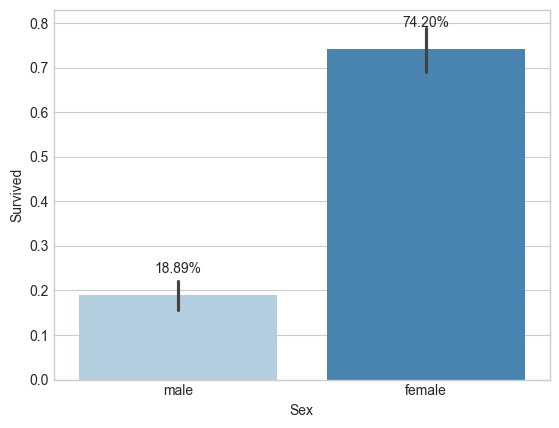

In [16]:
ax = sns.barplot(x='Sex', y='Survived', data=df, hue = "Sex", palette = "Blues")
for c in ax.patches:
    height = c.get_height()
    ax.text(c.get_x() + c.get_width()/2., height + 0.05,
            f'{height:.2%}', ha="center")

- Females had a significantly higher survival rate and count.
- Most survivors were women; most men did not survive.

## 🎯 Pclass vs Survival (Countplot + Barplot)

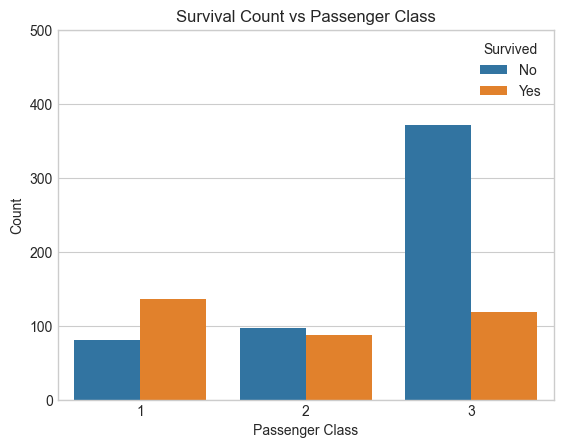

In [17]:
ax = sns.countplot(x = 'Pclass', hue = 'Survived', data = df)

ax.legend(title = "Survived", labels = ["No", "Yes"])

plt.title("Survival Count vs Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Count")

plt.ylim(top=500)  
plt.show()

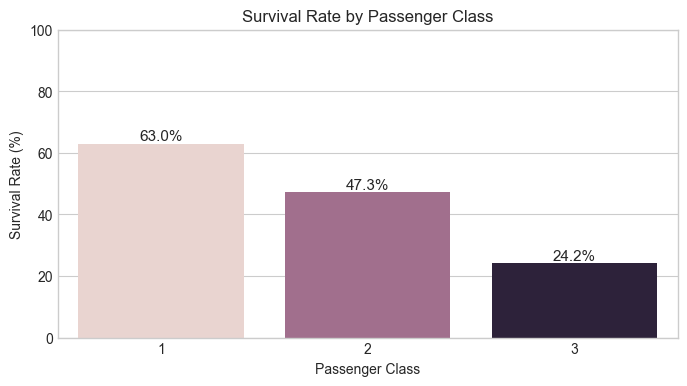

In [18]:
#Calculating the survival rates in each Passenger Class
survival_rates = df.groupby('Pclass')['Survived'].mean().reset_index()
survival_rates['Survived'] *= 100 

# Plot survival rate by Passenger class
plt.figure(figsize=(8, 4))
sns.barplot(x='Pclass', y='Survived', data=survival_rates, hue='Pclass', legend=False)

plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate (%)')

# Add percentage labels on top of bars
for i, row in survival_rates.iterrows():
    plt.text(i, row['Survived'] + 1, f'{row["Survived"]:.1f}%', ha='center', fontsize=11)

plt.ylim(0, 100)
plt.show()

- Passengers in 1st class had the highest survival rate, while 3rd class had the lowest.
- Pclass strongly influenced survival — indicates socioeconomic status was a factor.


## 🎯 Embarked vs Survival (Countplot + Barplot)

<Axes: xlabel='Embarked', ylabel='count'>

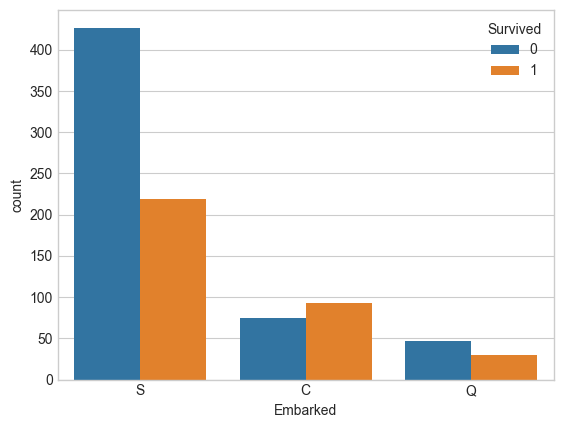

In [19]:
sns.countplot(x = 'Embarked', hue = 'Survived', data =df)

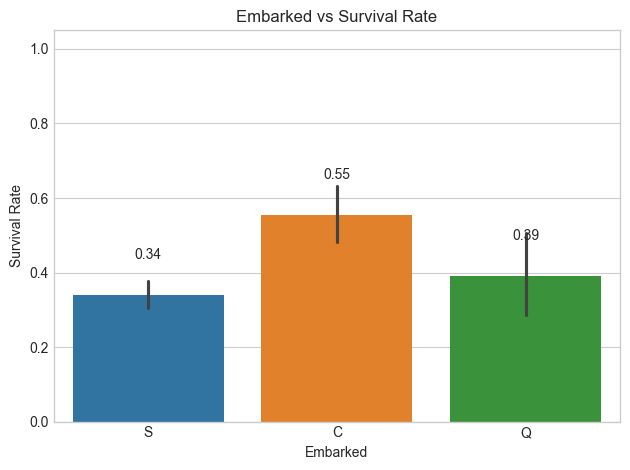

In [20]:
ax = sns.barplot(x = "Embarked", y = "Survived", data = df, hue = "Embarked") 
for c in ax.containers:
    ax.bar_label(c, fmt='%.2f', label_type='edge', padding=24)

plt.title("Embarked vs Survival Rate")
plt.xlabel("Embarked")
plt.ylabel("Survival Rate")
plt.ylim(0, 1.05)
plt.tight_layout()

plt.show()

- Passengers from port C (Cherbourg) had the highest survival rate.

- Most passengers were from port S (Southampton), which had the lowest survival rate.

<Axes: xlabel='Title'>

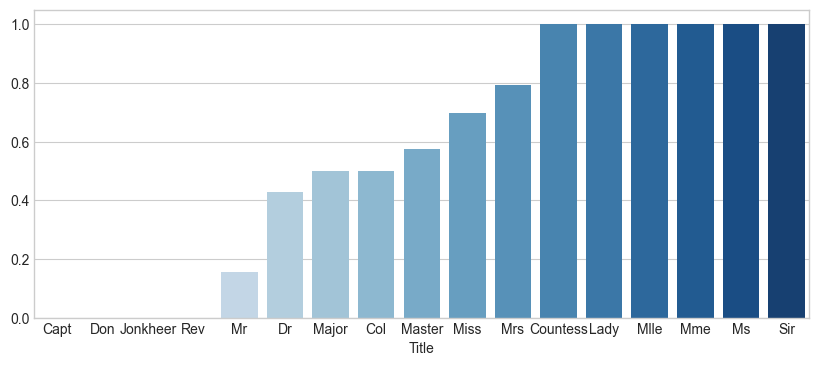

In [21]:
title_survival = df.groupby('Title')['Survived'].mean().sort_values()
plt.figure(figsize = (10,4))
sns.barplot(x=title_survival.index, y=title_survival.values, hue = title_survival.index, palette = "Blues")

- Perfect survival: All nobility (Countess, Lady, Sir) and French titles (Mlle, Mme) - 100%
- High female survival: Mrs (80%), Miss (70%) - "women first" protocol
- Male hierarchy: Master (boys, 58%) > Dr/Major/Col (50%) > Mr (15%) > Capt (0%)
- Class trumps gender: Noble men survived better than common women

## 🎯 Age vs Survival Density Plot

<Axes: xlabel='Age', ylabel='Density'>

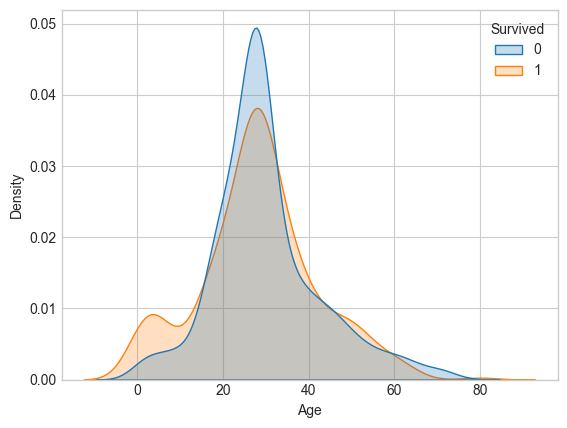

In [22]:
sns.kdeplot(data=df, x='Age', hue='Survived', fill=True, common_norm=False)

<Axes: xlabel='Survived', ylabel='Age'>

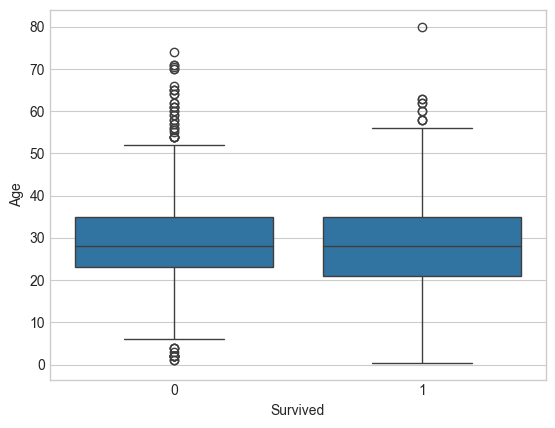

In [23]:
sns.boxplot(x='Survived', y='Age', data=df)

- The distribution of survivors shows a noticeable peak among younger ages (children), indicating a higher survival rate for children.
- Non-survivors appear to be more concentrated in the adult age ranges. The density of non-survivors is generally higher across most adult age groups compared to survivors.
- There are fewer elderly survivors.

## 🎯 Fare Distribution (KDE Plot)

<Axes: xlabel='Fare', ylabel='Density'>

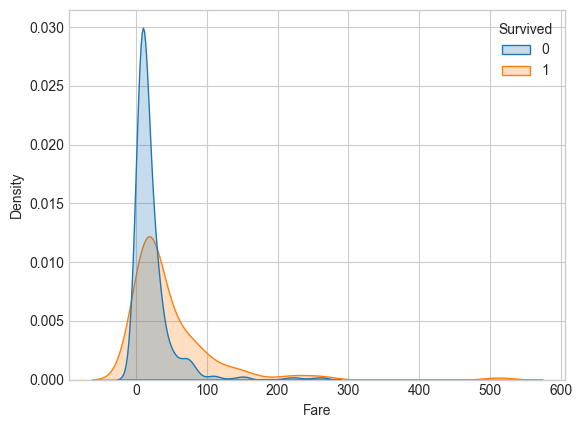

In [24]:
sns.kdeplot(data = df, x = 'Fare', hue = 'Survived', fill = True, common_norm = False)

- Clear fare-survival relationship: Survivors (orange) show a much broader fare distribution extending to higher values, while non-survivors (blue) are heavily concentrated in the low-fare range
- Low-fare dominance: The majority of passengers paid very low fares (peak around £10-20), with non-survivors making up most of this group
- High-fare advantage: Passengers who paid higher fares (£50+) had much better survival chances, though they were fewer in number
- Minimal overlap: There's surprisingly little overlap between the two distributions in the mid-range fares (£30-80)

## 🎯 Correlation Heatmap

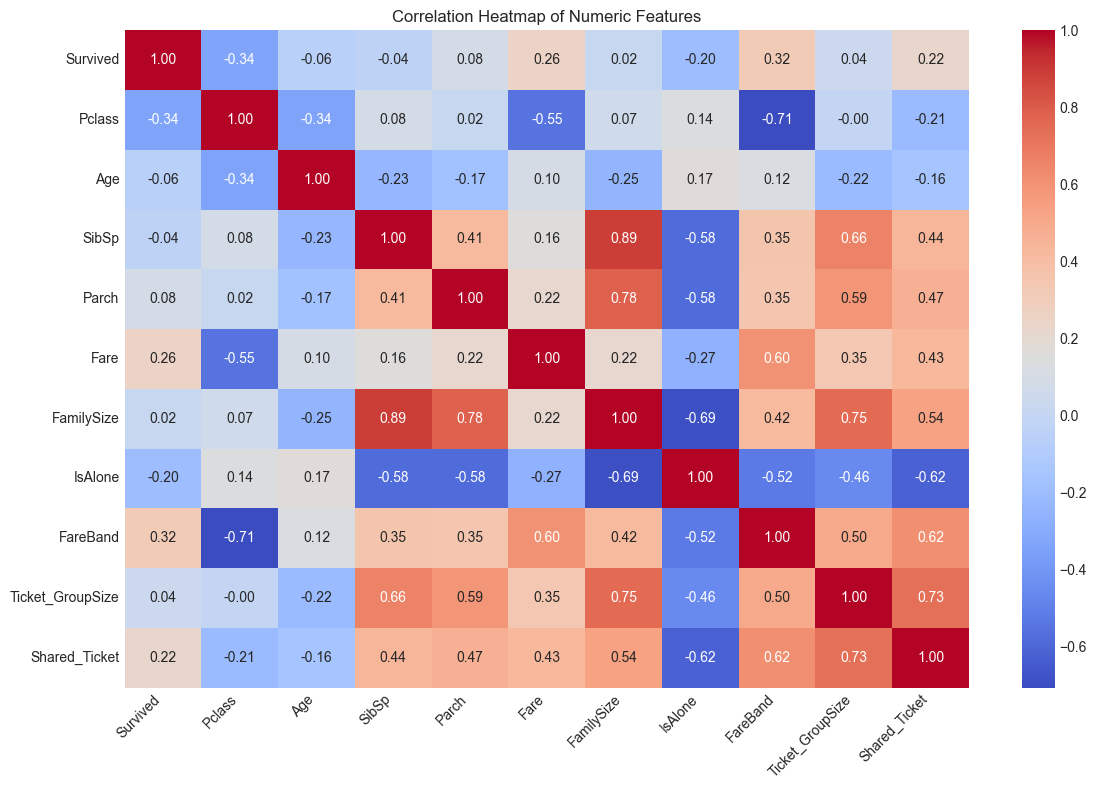

In [25]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")

plt.xticks(rotation=45, ha='right')
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

- Survival patterns: Strong negative correlation between Pclass and Survived (-0.34), indicating lower passenger classes had lower survival rates
- Family dynamics: Moderate positive correlation between SibSp and Parch (0.41), showing siblings/spouses often traveled with parents/children
- Fare relationships: Strong correlations between Fare and Pclass (-0.55), and Fare and Survived (0.26), suggesting higher fares meant better class and survival chances
- Group dynamics: Ticket_GroupSize shows interesting correlations with family size variables

## 🎯Family Size vs Survival

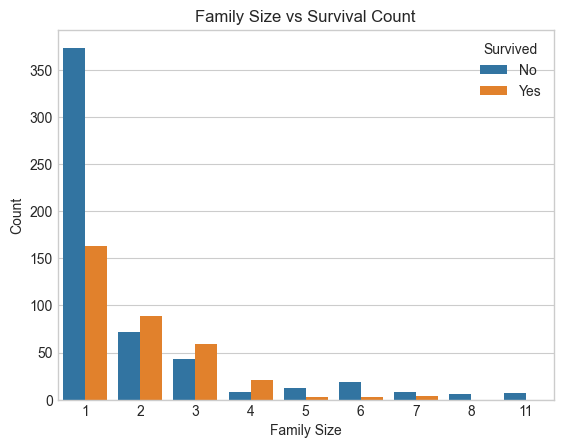

In [26]:
ax = sns.countplot(x = "FamilySize", hue = "Survived", data = df)

ax.legend(title = "Survived", labels = ['No','Yes'])

plt.title("Family Size vs Survival Count")
plt.xlabel("Family Size")
plt.ylabel("Count")

plt.show()

- Passengers with small family sizes (1–3) had higher survival rates.

- Very large families (6–7+) had lower survival — possibly due to coordination challenges.

## 🎯 Fareband vs Survival Rate

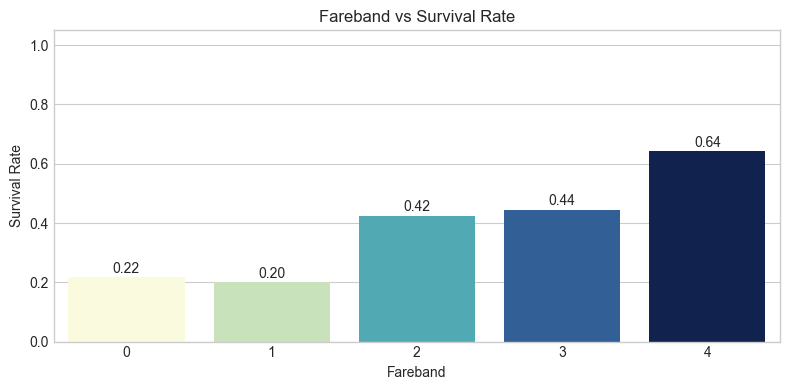

In [27]:
plt.figure(figsize = (8,4))
ax = sns.barplot(x = "FareBand", y = "Survived" , data = df, palette="YlGnBu", hue="FareBand", legend = False, errorbar=None)

for c in ax.containers:
    ax.bar_label(c, fmt='%.2f', label_type='edge', padding=1)

plt.title("Fareband vs Survival Rate")
plt.xlabel("Fareband")
plt.ylabel("Survival Rate")
plt.ylim(0, 1.05)
plt.tight_layout()

plt.show()

- Higher fare bands correlated with higher survival rates.
- Passengers who paid more had better survival chances — consistent with the Pclass trend.

## 🎯 Ticket Group Size vs Survival Count

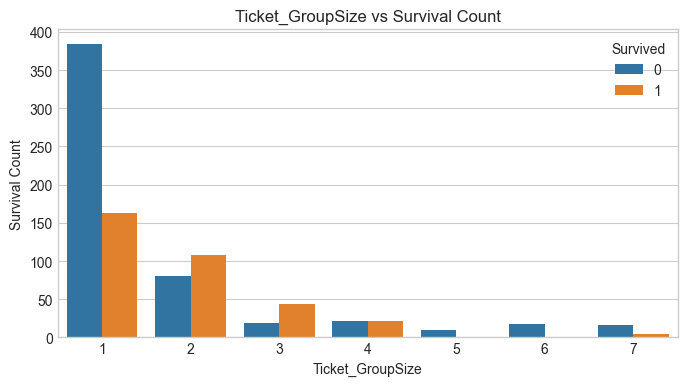

In [28]:
plt.figure(figsize = (8,4))
sns.countplot(x = "Ticket_GroupSize", hue = "Survived", data = df)
plt.xlabel("Ticket_GroupSize")
plt.ylabel("Survival Count")
plt.title("Ticket_GroupSize vs Survival Count")
plt.show()

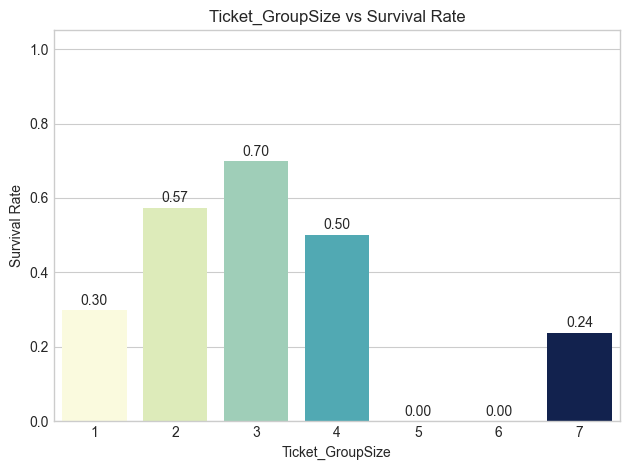

In [29]:
ax = sns.barplot(x = "Ticket_GroupSize", y = "Survived", data = df, errorbar=None, palette = "YlGnBu", hue = "Ticket_GroupSize", legend = False)
for c in ax.containers:
    ax.bar_label(c, fmt='%.2f', label_type='edge', padding=2)

plt.title("Ticket_GroupSize vs Survival Rate")
plt.xlabel("Ticket_GroupSize")
plt.ylabel("Survival Rate")
plt.ylim(0, 1.05)
plt.tight_layout()

- Optimal group size: Groups of 2-3 people had the highest survival rates (~57-70%)
- Solo travelers: Single passengers had relatively low survival rates (~30%)
- Large groups suffered: Groups of 4+ people showed declining survival rates
- Very large groups: Groups of 6-7 had extremely poor survival outcomes

## Preprocessing & Model Training

In [71]:
df_tree = df.copy()
df_linear = df.copy()

#### For Linear & Distance-based Models- Logistic Regression, SVM, KNN, GaussianNB

In [72]:
df_linear['Title'] = df_linear['Title'].replace({
    'Mlle': 'Miss',
    'Ms': 'Miss',
    'Mme': 'Mrs',
    'Lady': 'Noble',
    'Countess': 'Noble',
    'Sir': 'Noble',
    'Don': 'Noble',
    'Dona': 'Noble',
    'Capt': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Dr': 'Dr',
    'Rev': 'Officer',
    'Jonkheer': 'Rare'
})

In [73]:
# Dropped Ticket_Prefix column because of its high cardinality which causes problem while one hot encoding the categorical problems
df_linear.drop(['Ticket_Prefix'], axis = 1, inplace = True)

In [74]:
X = df_linear.drop(['Survived'], axis = 1)
y = df_linear['Survived']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [76]:
categorical_columns = ['Sex','Embarked','Title']
encoder = OneHotEncoder(sparse_output = False, handle_unknown='ignore')

train_encoded_array = encoder.fit_transform(X_train[categorical_columns])
train_encoded_df = pd.DataFrame(
    train_encoded_array,
    columns=encoder.get_feature_names_out(categorical_columns),
    index=X_train.index  
)
# Transform on test data
test_encoded_array = encoder.transform(X_test[categorical_columns])
test_encoded_df = pd.DataFrame(
    test_encoded_array,
    columns=encoder.get_feature_names_out(categorical_columns),
    index=X_test.index 
)

# Drop original categorical columns
X_train = X_train.drop(columns=categorical_columns)
X_test = X_test.drop(columns=categorical_columns)

# Concatenate encoded columns back
X_train = pd.concat([X_train, train_encoded_df], axis=1)
X_test = pd.concat([X_test, test_encoded_df], axis=1)

In [77]:
results = []

models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'SVM (Linear Kernel)': SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced'),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, weights='distance'),
    'Gaussian Naive Bayes': GaussianNB()
}

for name, model in models.items():
    print(f"\n Training and Evaluating: {name}")
    print("=" * (12 + len(name)))

    # Use scaling for all except Naive Bayes
    if name != "Gaussian Naive Bayes":
        clf = Pipeline([
            ("scaler", StandardScaler()),
            ("model", model)
        ])
    else:
        clf = Pipeline([
            ("model", model)
        ])

    # Fit and predict
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)

    # Cross-validation (on training set only)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    # Metrics
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f" Accuracy on test set: {acc_score:.4f}")
    print(f" Cross-Val Accuracy: {cv_mean:.4f} ± {cv_std:.4f}")
    print(f" Confusion Matrix:\n{pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1'])}\n")

    print(" Classification Report Summary:")
    print(f"  - Precision (class 0): {report['0']['precision']:.2f}")
    print(f"  - Recall    (class 0): {report['0']['recall']:.2f}")
    print(f"  - F1-score  (class 0): {report['0']['f1-score']:.2f}")
    print(f"  - Precision (class 1): {report['1']['precision']:.2f}")
    print(f"  - Recall    (class 1): {report['1']['recall']:.2f}")
    print(f"  - F1-score  (class 1): {report['1']['f1-score']:.2f}")

    # Store all results
    results.append({
        'Model': name,
        'Test Accuracy': acc_score,
        'CV Accuracy Mean': cv_mean,
        'CV Accuracy Std': cv_std,
        'Precision_0': report['0']['precision'],
        'Recall_0': report['0']['recall'],
        'F1_0': report['0']['f1-score'],
        'Precision_1': report['1']['precision'],
        'Recall_1': report['1']['recall'],
        'F1_1': report['1']['f1-score']
    })

# Summary Table
summary_df = pd.DataFrame(results)
print("\n📋 Final Summary Table:")
print(summary_df.set_index("Model").round(3))


 Training and Evaluating: Logistic Regression
 Accuracy on test set: 0.8358
 Cross-Val Accuracy: 0.8137 ± 0.0257
 Confusion Matrix:
          Pred 0  Pred 1
Actual 0     145      20
Actual 1      24      79

 Classification Report Summary:
  - Precision (class 0): 0.86
  - Recall    (class 0): 0.88
  - F1-score  (class 0): 0.87
  - Precision (class 1): 0.80
  - Recall    (class 1): 0.77
  - F1-score  (class 1): 0.78

 Training and Evaluating: SVM (Linear Kernel)
 Accuracy on test set: 0.8321
 Cross-Val Accuracy: 0.8217 ± 0.0370
 Confusion Matrix:
          Pred 0  Pred 1
Actual 0     144      21
Actual 1      24      79

 Classification Report Summary:
  - Precision (class 0): 0.86
  - Recall    (class 0): 0.87
  - F1-score  (class 0): 0.86
  - Precision (class 1): 0.79
  - Recall    (class 1): 0.77
  - F1-score  (class 1): 0.78

 Training and Evaluating: K-Nearest Neighbors
 Accuracy on test set: 0.7948
 Cross-Val Accuracy: 0.7913 ± 0.0136
 Confusion Matrix:
          Pred 0  Pred 1


#### For Tree based Models- DecisionTreeClassifier, RandomForestClassfier, CatBoostClassifier,LightGBMClassifier, XGBoostClassifier

In [78]:
df_tree['Sex'] = df_tree['Sex'].map({"male": 0, "female": 1})
df_tree["Embarked"] = df_tree["Embarked"].map({"S": 0, "C": 1, "Q": 2}) 

In [79]:
categorical_columns = ['Title', 'Ticket_Prefix']
X = df_tree.drop('Survived', axis = 1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [80]:
results = []
models = {
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Random Forest CLassifier': RandomForestClassifier(),
    'Light GBM Classifier': LGBMClassifier(verbose=-1),
    'XG Boost Classifier': XGBClassifier(verbosity=0),
    'Cat Boost Classifier': CatBoostClassifier(verbose=0)
}

for name, model in models.items():
    print(f"\n Training and Evaluating: {name}")
    print("=" * (12 + len(name)))

    clf = Pipeline([
        ('target_encoder', ce.TargetEncoder(cols = categorical_columns)),\
        ('model', model)
    ])
    # Fit and predict
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)

    # Cross-validation (on training set only)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    # Metrics
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f" Accuracy on test set: {acc_score:.4f}")
    print(f" Cross-Val Accuracy: {cv_mean:.4f} ± {cv_std:.4f}")
    print(f" Confusion Matrix:\n{pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1'])}\n")

    print(" Classification Report Summary:")
    print(f"  - Precision (class 0): {report['0']['precision']:.2f}")
    print(f"  - Recall    (class 0): {report['0']['recall']:.2f}")
    print(f"  - F1-score  (class 0): {report['0']['f1-score']:.2f}")
    print(f"  - Precision (class 1): {report['1']['precision']:.2f}")
    print(f"  - Recall    (class 1): {report['1']['recall']:.2f}")
    print(f"  - F1-score  (class 1): {report['1']['f1-score']:.2f}")

    # Store all results
    results.append({
        'Model': name,
        'Test Accuracy': acc_score,
        'CV Accuracy Mean': cv_mean,
        'CV Accuracy Std': cv_std,
        'Precision_0': report['0']['precision'],
        'Recall_0': report['0']['recall'],
        'F1_0': report['0']['f1-score'],
        'Precision_1': report['1']['precision'],
        'Recall_1': report['1']['recall'],
        'F1_1': report['1']['f1-score']
    })

# Summary Table
summary_df = pd.DataFrame(results)
print("\n📋 Final Summary Table:")
print(summary_df.set_index("Model").round(3))


 Training and Evaluating: Decision Tree Classifier
 Accuracy on test set: 0.7598
 Cross-Val Accuracy: 0.7544 ± 0.0442
 Confusion Matrix:
          Pred 0  Pred 1
Actual 0      91      19
Actual 1      24      45

 Classification Report Summary:
  - Precision (class 0): 0.79
  - Recall    (class 0): 0.83
  - F1-score  (class 0): 0.81
  - Precision (class 1): 0.70
  - Recall    (class 1): 0.65
  - F1-score  (class 1): 0.68

 Training and Evaluating: Random Forest CLassifier
 Accuracy on test set: 0.7989
 Cross-Val Accuracy: 0.8120 ± 0.0529
 Confusion Matrix:
          Pred 0  Pred 1
Actual 0      93      17
Actual 1      19      50

 Classification Report Summary:
  - Precision (class 0): 0.83
  - Recall    (class 0): 0.85
  - F1-score  (class 0): 0.84
  - Precision (class 1): 0.75
  - Recall    (class 1): 0.72
  - F1-score  (class 1): 0.74

 Training and Evaluating: Light GBM Classifier
 Accuracy on test set: 0.8156
 Cross-Val Accuracy: 0.8077 ± 0.0277
 Confusion Matrix:
          Pred

In [81]:
model_params = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'model__max_depth': [3, 5, 10, None],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    'Random Forest Classifier': {
        'model': RandomForestClassifier(),
        'params': {
            'model__n_estimators': [100, 200, 500],
            'model__max_depth': [5, 10, None],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    'XG Boost Classifier': {
        'model': XGBClassifier(verbosity = 0),
        'params': {
            'model__n_estimators': [100, 200, 500],
            'model__max_depth': [3, 6, 10],
            'model__learning_rate': [0.01, 0.05, 0.1]
        }
    },
    ##'Light GBM Classifier': {
    ##    'model': LGBMClassifier(verbose = -1, device='gpu'),
    ##    'params': {
    ##    'model__n_estimators': [100, 200, 500],
    ##        'model__learning_rate': [0.01, 0.05, 0.1],
    ##        'model__num_leaves': [15, 31, 63]
    ##    }
    ##},
    'Light GBM Classifier': {
        'model': LGBMClassifier(verbose=-1, device='cpu'),  # do NOT use 'gpu'
        'params': {
            'model__n_estimators': [100],         # only 1 value
            'model__learning_rate': [0.05],
            'model__num_leaves': [15]
        }
    },
    ##'Cat Boost Classifier': {
    ##    'model': CatBoostClassifier(verbose = 0, task_type='GPU', thread_count=4),
    ##    'params': {
    ##        'model__iterations': [100, 200, 500],
    ##        'model__depth': [4, 6, 10],
    ##        'model__learning_rate': [0.01, 0.05, 0.1]
    ##    }
    ##}
    'Cat Boost Classifier': {
        'model': CatBoostClassifier(verbose=0, task_type='CPU', thread_count=2),  # reduce threads
        'params': {
            'model__iterations': [100],        # only 1 value
            'model__depth': [4],
            'model__learning_rate': [0.05],
            'model__l2_leaf_reg': [1, 3, 5, 10],
            'model__bootstrap_type': ['Bayesian', 'Bernoulli'],
        }
    }
}

In [88]:
results = []
for name, mp in model_params.items():
    print(f"\n🔧 Tuning: {name}")
    start_time = time.time()

    # Build pipeline
    pipe = Pipeline([
        ('target_encoder', ce.TargetEncoder(cols=categorical_columns)),
        ('model', mp['model'])
    ])

    # Randomized Search CV
    search = RandomizedSearchCV(
        pipe,
        mp['params'],
        n_iter=1,
        cv=2,
        n_jobs=1,
        scoring='accuracy',
        verbose=0
    )
    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    
    # Cross-validation scores (with full pipeline)
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
    
    # Test set evaluation
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f"✅ Best Params: {search.best_params_}")
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"⏱️ Time Taken: {(time.time() - start_time):.2f} sec")

    results.append({
        'Model': name,
        'Test Accuracy': acc,
        'CV Accuracy Mean': cv_scores.mean(),
        'CV Accuracy Std': cv_scores.std(),
        'Precision_0': report['0']['precision'],
        'Recall_0': report['0']['recall'],
        'F1_0': report['0']['f1-score'],
        'Precision_1': report['1']['precision'],
        'Recall_1': report['1']['recall'],
        'F1_1': report['1']['f1-score']
    })


🔧 Tuning: Decision Tree
✅ Best Params: {'model__min_samples_split': 2, 'model__max_depth': 5}
✅ Accuracy: 0.7821
⏱️ Time Taken: 0.11 sec

🔧 Tuning: Random Forest Classifier
✅ Best Params: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__max_depth': 10}
✅ Accuracy: 0.8101
⏱️ Time Taken: 1.22 sec

🔧 Tuning: XG Boost Classifier
✅ Best Params: {'model__n_estimators': 500, 'model__max_depth': 3, 'model__learning_rate': 0.1}
✅ Accuracy: 0.8212
⏱️ Time Taken: 0.84 sec

🔧 Tuning: Light GBM Classifier
✅ Best Params: {'model__num_leaves': 15, 'model__n_estimators': 100, 'model__learning_rate': 0.05}
✅ Accuracy: 0.7989
⏱️ Time Taken: 0.30 sec

🔧 Tuning: Cat Boost Classifier
✅ Best Params: {'model__learning_rate': 0.05, 'model__l2_leaf_reg': 1, 'model__iterations': 100, 'model__depth': 4, 'model__bootstrap_type': 'Bernoulli'}
✅ Accuracy: 0.8156
⏱️ Time Taken: 0.44 sec


In [89]:
summary_df = pd.DataFrame(results)
summary_df = summary_df.set_index('Model')

print("\n📋 Final Summary Table:")
print(summary_df.round(3).sort_values(by='Test Accuracy', ascending=False))


📋 Final Summary Table:
                          Test Accuracy  CV Accuracy Mean  CV Accuracy Std  \
Model                                                                        
XG Boost Classifier               0.821             0.815            0.024   
Cat Boost Classifier              0.816             0.823            0.012   
Random Forest Classifier          0.810             0.820            0.033   
Light GBM Classifier              0.799             0.809            0.025   
Decision Tree                     0.782             0.803            0.033   

                          Precision_0  Recall_0   F1_0  Precision_1  Recall_1  \
Model                                                                           
XG Boost Classifier             0.836     0.882  0.858        0.794     0.725   
Cat Boost Classifier            0.829     0.882  0.855        0.790     0.710   
Random Forest Classifier        0.833     0.864  0.848        0.769     0.725   
Light GBM Classifier    

In [91]:
# Select categorical columns for target encoding
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

# Define the column transformer with target encoding for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('target_enc', ce.TargetEncoder(), cat_cols)
    ],
    remainder='passthrough'  # Leave other columns as-is (numeric features)
)

best_xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, verbosity=0)
best_cat = CatBoostClassifier(
    learning_rate=0.05,
    iterations=100,
    depth=4,
    l2_leaf_reg=1,
    bootstrap_type='Bernoulli',
    verbose=0
)
best_rf = RandomForestClassifier(n_estimators=200, min_samples_split=2, max_depth=10)

voting_clf = VotingClassifier(
    estimators=[
        ('xgb', best_xgb),
        ('cat', best_cat),
        ('rf', best_rf)
    ],
    voting='soft'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', voting_clf)
])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy Score: 0.8212290502793296
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       110
           1       0.80      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



In [93]:
results.append({
    'Model': 'Voting Classifier',
    'Test Accuracy': 0.821,
    'CV Accuracy Mean': cross_val_score(pipeline, X_train, y_train, cv=5).mean(),
    'CV Accuracy Std': cross_val_score(pipeline, X_train, y_train, cv=5).std(),
    'Precision_0': 0.83,
    'Recall_0': 0.89,
    'F1_0': 0.86,
    'Precision_1': 0.80,
    'Recall_1': 0.71,
    'F1_1': 0.75
})

summary_df = pd.DataFrame(results).set_index("Model")
summary_df = summary_df.round(3).sort_values(by="Test Accuracy", ascending=False)

print("\n📋 Final Model Comparison Table with VotingClassifier Included:\n")
print(summary_df)


📋 Final Model Comparison Table with VotingClassifier Included:

                          Test Accuracy  CV Accuracy Mean  CV Accuracy Std  \
Model                                                                        
Voting Classifier                 0.821             0.815            0.026   
XG Boost Classifier               0.821             0.815            0.024   
Cat Boost Classifier              0.816             0.823            0.012   
Random Forest Classifier          0.810             0.820            0.033   
Light GBM Classifier              0.799             0.809            0.025   
Decision Tree                     0.782             0.803            0.033   

                          Precision_0  Recall_0   F1_0  Precision_1  Recall_1  \
Model                                                                           
Voting Classifier               0.830     0.890  0.860        0.800     0.710   
XG Boost Classifier             0.836     0.882  0.858        0.794

In [94]:
# Saving the trained pipeline
joblib.dump(pipeline, '../models/best_model.pkl')

['../models/best_model.pkl']

##### Loading up the saved model and using it
```python
loaded_model = joblib.load('best_model.pkl')
y_pred = loaded_model.predict(X_test)
```

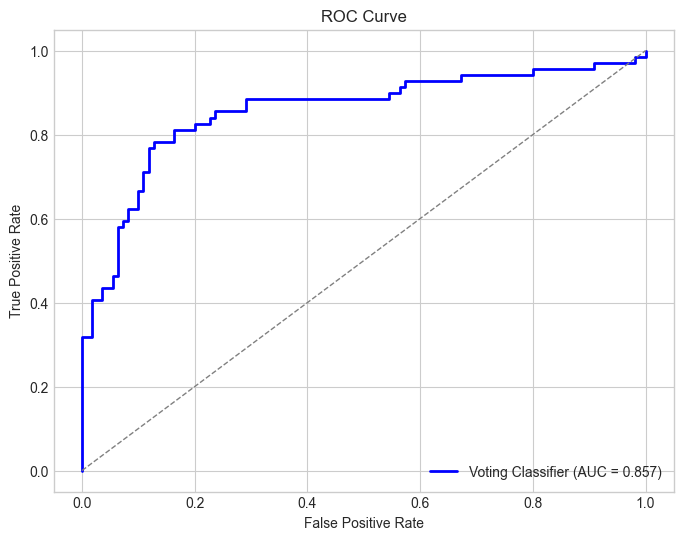

In [101]:
y_prob = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Voting Classifier (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

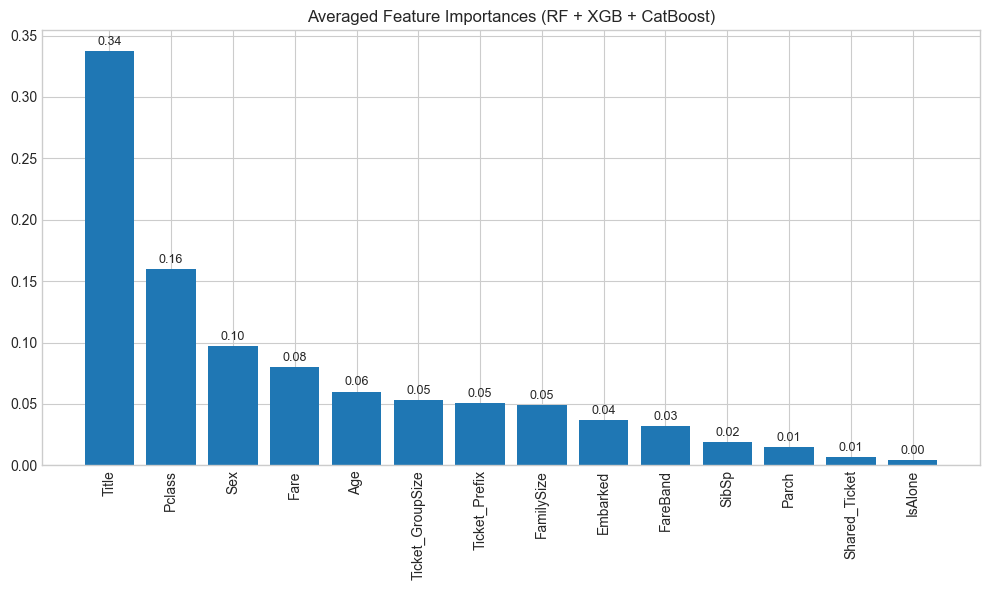

In [105]:
rf_model = pipeline.named_steps['classifier'].named_estimators_['rf']
xgb_model = pipeline.named_steps['classifier'].named_estimators_['xgb']
cat_model = pipeline.named_steps['classifier'].named_estimators_['cat']

rf_imp = rf_model.feature_importances_
xgb_imp = xgb_model.feature_importances_
cat_imp = cat_model.get_feature_importance()

avg_imp =  (rf_imp / rf_imp.sum() + xgb_imp / xgb_imp.sum() + cat_imp / cat_imp.sum()) / 3

feature_names = (
    pipeline.named_steps['preprocessor']
    .named_transformers_['target_enc']
    .get_feature_names_out(cat_cols)
    .tolist()
    + [col for col in X_train.columns if col not in cat_cols]
)

indices = np.argsort(avg_imp)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Averaged Feature Importances (RF + XGB + CatBoost)")
plt.bar(range(len(avg_imp)), avg_imp[indices], align='center')
for i, v in enumerate(avg_imp[indices]):
    plt.text(i, v + 0.005, f"{v:.2f}", ha='center', fontsize=9)
plt.xticks(range(len(avg_imp)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.grid(True)
plt.show()

In [107]:
plt.savefig("../feature_importance.png", bbox_inches="tight", dpi=300)

<Figure size 640x480 with 0 Axes>

## 🔚 Conclusion
In this project, I explored the **Titanic survival prediction** problem using a variety of classification models including **Decision Trees**, **Random Forests**, **XGBoost**, **LightGBM**, and **CatBoost**. After extensive **preprocessing** and **feature engineering** (e.g., Title extraction, Ticket grouping, Family features), I applied **target encoding** for categorical variables to better suit tree-based models.

Each model was tuned using **RandomizedSearchCV**, and a *8VotingClassifier** ensemble (combining XGBoost, CatBoost, and Random Forest) achieved the **highest test accuracy of ~82.1%**, with an **AUC score of 0.857** — indicating strong discriminative ability.

**Feature importance** analysis revealed that **Title**, **Pclass**, and **Sex** were the most influential features in predicting survival, which aligns with historical evacuation priorities on the Titanic. This project demonstrates how combining domain understanding, feature engineering, and ensemble learning can lead to robust and interpretable models.

Overall, this has been a valuable experience in applying end-to-end machine learning workflows — from data preprocessing to model selection, evaluation, and interpretation.